In [1]:
import paho.mqtt.client as paho
import numpy as np
import random
import json
import networkx as nx
from node import EpidemicGraph, TransitionDiagram, calc_R0
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
# %matplotlib inline

In [2]:
broker_ip = '192.168.0.104'
broker_ip = 'localhost'
# broker_ip = '10.1.199.251'
# broker_ip = '10.101.6.111'
connflag = False

In [3]:
def plot(G, title='step_1', ns=1000, fs=12, lim=2, figsize=(5, 5)):
    pos = nx.get_node_attributes(G, 'position')
    ids = {i:i for i in range(N)}
    print('Total node number', N)

    s_a = [x for x,y in G.nodes(data=True) if y['state']=='S_a']
    s_s = [x for x,y in G.nodes(data=True) if y['state']=='S_s']
    i1_a = [x for x,y in G.nodes(data=True) if y['state']=='I1_a']
    i1_s = [x for x,y in G.nodes(data=True) if y['state']=='I1_s']
    i2_a = [x for x,y in G.nodes(data=True) if y['state']=='I2_a']
    i2_s = [x for x,y in G.nodes(data=True) if y['state']=='I2_s']


    fig = plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G, pos, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_a, node_color='#66ff99')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_s, node_color='#006600')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_a, node_color='#ff6666')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_s, node_color='#cc0000')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_a, node_color='#3399ff')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_s, node_color='#0000cc')
    nx.draw_networkx_labels(G, pos, ids, font_size=fs)

    plt.title(title)
    red_patch = mpatches.Patch(color='red', label='I1')
    blue_patch = mpatches.Patch(color='blue', label='I2')
    green_patch = mpatches.Patch(color='green', label='S')
    plt.legend(handles=[green_patch, red_patch, blue_patch])
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    return plt, fig

In [4]:
mqttc = paho.Client()
counter = 0
N = 20
format_date = "%d %b %Y %H%M%S.%f"

def on_connect(client, userdata, flags, rc):
    global connflag
    #if connection is successful, rc value will be 0
    print("Connection returned result: " + str(rc) )
    connflag = True

def on_message(client, userdata, msg): 
    print("-t {} | -p {}".format(msg.topic, msg.payload.decode()) )
    
def on_state(client, userdata, msg): 
    global G, counter
    counter += 1
    name = datetime.now().strftime(format_date)
    js = json.loads(msg.payload.decode())
    G.node[js['id']]['state'] = js['state']
    if counter%N == 0:
        plt, fig = plot(G, 'step {}'.format((counter-1)//N), **plt_set)
        fig.savefig('figures/{}.png'.format(name))
        plt.close()
    log = "-t {} | -p {}".format(msg.topic, msg.payload.decode())
    print( log)
    with open("log.txt", "a") as myfile:
        myfile.write("{},{}\n".format(name, log))
        
def on_finish(client, userdata, msg):  # on finish step
    global node_set
    log = "-t {} | -p {}".format(msg.topic, msg.payload.decode())
    with open("log_node_set.txt", "a") as myfile:
        myfile.write("{}\n".format(log))
    node_id = msg.payload.decode()
    node_set.remove(node_id)
    print(node_set)
#     with open("log_node_set.txt", "a") as myfile:
#         myfile.write("{},{}\n".format(node_set))
    if len(node_set) == 0:
        mqttc.publish('next', 'dummy_msg', qos=2)
        node_set = {str(x) for x in range(N)}
    
    
node_set = {str(x) for x in range(N)}
mqttc.on_connect = on_connect
mqttc.on_message = on_message
mqttc.message_callback_add("state", on_state)
mqttc.message_callback_add("finish", on_finish)

mqttc.connect(broker_ip)
mqttc.loop_start()
mqttc.subscribe('state', 2)
mqttc.subscribe('finish', 2)

(0, 2)

Connection returned result: 0


(6.714202358824712, 6.714202358824712) (1, 0)
Total node number 20


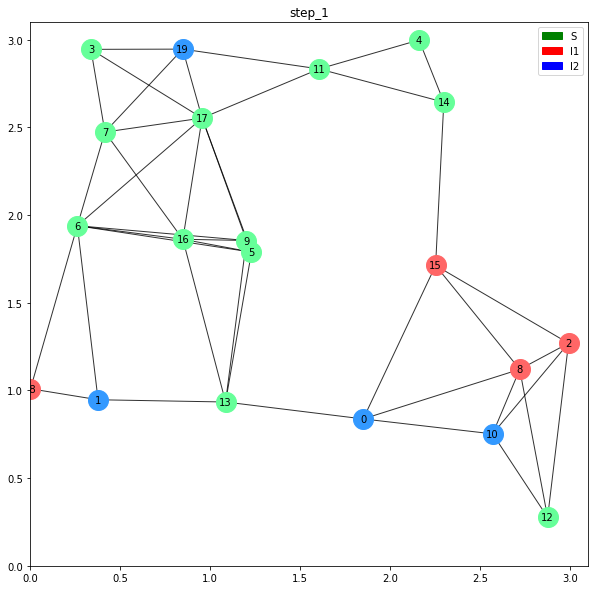

In [8]:
paramet = {
        'alpha': [0.5, 0.5], # infect rate 
        'mu': [0.5, 0.5], # sleep s 
        'gamma': [0.1, 0.1], # rec rate 
        'lambda': [0.7, 0.2], # sleep I1 
        'kappa': [0.7, 0.2] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
    }
np.random.seed(315)  # structure
random.seed(6)       # infected
# N = 5
r = 1
number_subgraphs = 0

while number_subgraphs != 1:
    a = EpidemicGraph(N,r,paramet,I1_a=4, I2_a=4, grid_size=[3,3], create=True) # net='Uniform Grid'
    number_subgraphs = len(list(nx.connected_component_subgraphs(a.G)))
    number_isolated_nodes = len(list(nx.isolates(a.G)))
    print(calc_R0(a.G, paramet), (number_subgraphs, number_isolated_nodes))

G = a.G
# G.node[0]['state'] = 'S_s'

plt_set = {
    'ns': 400, 
    'fs': 10,
    'lim': 3.1, 
    'figsize': (10,10)
}
plt, fig = plot(G, **plt_set) #  ns=300, fs=6,lim=5
# plt.show()
fig.savefig('figures/_.png')

In [9]:
G.node[1]

msg_list = []
for node_id in range(N):
    neighbours = list(G[node_id])
    msg = {
        "id": node_id,
        "state": G.node[node_id]['state'],
        "neighbours": neighbours
    }
    msg_list.append(msg)
    print(msg)
    
mqttc.publish('init', json.dumps(msg_list))

{'id': 0, 'state': 'I2_a', 'neighbours': [8, 10, 13, 15]}
{'id': 1, 'state': 'I2_a', 'neighbours': [6, 13, 18]}
{'id': 2, 'state': 'I1_a', 'neighbours': [8, 10, 12, 15]}
{'id': 3, 'state': 'S_a', 'neighbours': [7, 17, 19]}
{'id': 4, 'state': 'S_a', 'neighbours': [11, 14]}
{'id': 5, 'state': 'S_a', 'neighbours': [6, 9, 13, 16, 17]}
{'id': 6, 'state': 'S_a', 'neighbours': [1, 5, 7, 9, 16, 17, 18]}
{'id': 7, 'state': 'S_a', 'neighbours': [3, 6, 16, 17, 19]}
{'id': 8, 'state': 'I1_a', 'neighbours': [0, 2, 10, 12, 15]}
{'id': 9, 'state': 'S_a', 'neighbours': [5, 6, 13, 16, 17]}
{'id': 10, 'state': 'I2_a', 'neighbours': [0, 2, 8, 12]}
{'id': 11, 'state': 'S_a', 'neighbours': [4, 14, 17, 19]}
{'id': 12, 'state': 'S_a', 'neighbours': [2, 8, 10]}
{'id': 13, 'state': 'S_a', 'neighbours': [0, 1, 5, 9, 16]}
{'id': 14, 'state': 'S_a', 'neighbours': [4, 11, 15]}
{'id': 15, 'state': 'I1_a', 'neighbours': [0, 2, 8, 14]}
{'id': 16, 'state': 'S_a', 'neighbours': [5, 6, 7, 9, 13, 17]}
{'id': 17, 'state':

In [ ]:
# node_set = {str(x) for x in range(5)}
# mqttc.publish('finish', '14', qos=2)
node_set


In [ ]:
mqttc.loop_stop()

In [ ]:
mqttc.publish('next', 'dummy_msg', qos=2)

In [ ]:
mqttc.publish('stop', 'dummy_msg', qos=2)

In [ ]:
mqttc.publish('kill', 'process die', qos=2)

In [ ]:
mqttc.publish('paramet', json.dumps(paramet), qos=2)

In [10]:
mqttc.publish('start', 'dummy_msg', qos=2)

-t state | -p {"step": 0, "state": "I2_a", "id": 0}
-t state | -p {"step": 0, "state": "I2_a", "id": 1}
-t state | -p {"step": 0, "state": "I1_a", "id": 2}
-t state | -p {"step": 0, "state": "S_a", "id": 3}
-t state | -p {"step": 0, "state": "S_a", "id": 4}
-t state | -p {"step": 0, "state": "S_a", "id": 5}
-t state | -p {"step": 0, "state": "S_a", "id": 6}
-t state | -p {"step": 0, "state": "S_a", "id": 7}
-t state | -p {"step": 0, "state": "I1_a", "id": 8}
-t state | -p {"step": 0, "state": "S_a", "id": 9}
{'7', '5', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '6', '13', '18'}
{'7', '5', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '6', '18'}
{'7', '5', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '6', '18'}
{'7', '5', '9', '4', '1', '16', '17', '14', '11', '12', '3', '19', '0', '2', '6', '18'}
{'7', '5', '9', '4', '1', '16', '17', '14', '11', '12', '3', '19', '0', '2', '6'}
{'7', '5', '9', '4

-t state | -p {"step": 4, "state": "I2_a", "id": 0}
-t state | -p {"step": 4, "state": "I2_a", "id": 1}
-t state | -p {"step": 4, "state": "I1_a", "id": 2}
-t state | -p {"step": 4, "state": "I2_a", "id": 3}
-t state | -p {"step": 4, "state": "S_s", "id": 4}
-t state | -p {"step": 4, "state": "S_s", "id": 5}
-t state | -p {"step": 4, "state": "I2_a", "id": 6}
-t state | -p {"step": 4, "state": "S_s", "id": 7}
-t state | -p {"step": 4, "state": "I1_s", "id": 8}
-t state | -p {"step": 4, "state": "I2_a", "id": 9}
-t state | -p {"state": "S_a", "id": 16, "step": 4}
-t state | -p {"state": "I2_s", "id": 17, "step": 4}
-t state | -p {"state": "I2_s", "id": 18, "step": 4}
-t state | -p {"state": "I2_s", "id": 19, "step": 4}
-t state | -p {"state": "I2_a", "id": 10, "step": 4}
-t state | -p {"state": "I2_a", "id": 11, "step": 4}
-t state | -p {"state": "I1_a", "id": 12, "step": 4}
-t state | -p {"state": "I2_a", "id": 13, "step": 4}
-t state | -p {"state": "S_s", "id": 14, "step": 4}
Total no

-t state | -p {"step": 7, "state": "I2_a", "id": 9}
{'4', '14', '11', '12', '15', '19', '10', '18'}
{'4', '14', '11', '12', '15', '10', '18'}
{'4', '14', '12', '15', '10', '18'}
{'4', '14', '15', '10', '18'}
{'4', '15', '10', '18'}
{'4', '15', '18'}
{'4', '18'}
{'4'}
set()
-t state | -p {"state": "I2_s", "id": 16, "step": 8}
-t state | -p {"state": "I2_a", "id": 17, "step": 8}
-t state | -p {"state": "I2_a", "id": 18, "step": 8}
-t state | -p {"state": "I2_a", "id": 19, "step": 8}
-t state | -p {"state": "I2_a", "id": 10, "step": 8}
-t state | -p {"state": "I2_s", "id": 11, "step": 8}
-t state | -p {"state": "I1_a", "id": 12, "step": 8}
-t state | -p {"state": "I2_s", "id": 13, "step": 8}
-t state | -p {"state": "I2_s", "id": 14, "step": 8}
-t state | -p {"state": "I1_a", "id": 15, "step": 8}
-t state | -p {"step": 8, "state": "I2_a", "id": 0}
-t state | -p {"step": 8, "state": "I2_a", "id": 1}
-t state | -p {"step": 8, "state": "S_a", "id": 2}
-t state | -p {"step": 8, "state": "I2_a"

{'4', '16', '14', '11', '12', '15', '19', '10', '13', '18'}
{'4', '16', '14', '11', '12', '15', '19', '10', '18'}
{'4', '14', '11', '12', '15', '19', '10', '18'}
{'4', '14', '11', '12', '15', '10', '18'}
{'4', '14', '12', '15', '10', '18'}
{'4', '14', '12', '15', '18'}
{'4', '14', '12', '18'}
{'4', '14', '12'}
{'4', '14'}
{'4'}
set()
-t state | -p {"step": 12, "state": "I2_a", "id": 0}
-t state | -p {"step": 12, "state": "I2_a", "id": 1}
-t state | -p {"step": 12, "state": "I2_a", "id": 2}
-t state | -p {"step": 12, "state": "I2_a", "id": 3}
-t state | -p {"step": 12, "state": "I2_a", "id": 4}
-t state | -p {"step": 12, "state": "I2_a", "id": 5}
-t state | -p {"step": 12, "state": "I2_a", "id": 6}
-t state | -p {"step": 12, "state": "I2_a", "id": 7}
-t state | -p {"step": 12, "state": "I1_a", "id": 8}
-t state | -p {"step": 12, "state": "I2_s", "id": 9}
-t state | -p {"state": "I2_s", "id": 16, "step": 12}
-t state | -p {"state": "I2_a", "id": 17, "step": 12}
-t state | -p {"state": "I

-t state | -p {"state": "I2_a", "id": 16, "step": 16}
-t state | -p {"state": "I2_a", "id": 17, "step": 16}
-t state | -p {"state": "I2_a", "id": 18, "step": 16}
-t state | -p {"state": "I2_s", "id": 19, "step": 16}
-t state | -p {"state": "I2_a", "id": 10, "step": 16}
-t state | -p {"state": "I2_s", "id": 11, "step": 16}
-t state | -p {"step": 16, "state": "I2_a", "id": 0}
-t state | -p {"state": "S_a", "id": 12, "step": 16}
-t state | -p {"state": "I2_s", "id": 13, "step": 16}
-t state | -p {"state": "I2_a", "id": 14, "step": 16}
-t state | -p {"state": "I2_a", "id": 15, "step": 16}
-t state | -p {"step": 16, "state": "I2_a", "id": 1}
-t state | -p {"step": 16, "state": "I2_a", "id": 2}
-t state | -p {"step": 16, "state": "I2_a", "id": 3}
-t state | -p {"step": 16, "state": "I2_a", "id": 4}
-t state | -p {"step": 16, "state": "I2_a", "id": 5}
-t state | -p {"step": 16, "state": "I2_s", "id": 6}
-t state | -p {"step": 16, "state": "I2_a", "id": 7}
-t state | -p {"step": 16, "state": "

-t state | -p {"state": "I2_s", "id": 16, "step": 20}
{'7', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '6', '13', '18'}
{'7', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '13', '18'}
{'9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '13', '18'}
{'4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '13', '18'}
-t state | -p {"state": "I2_s", "id": 17, "step": 20}
-t state | -p {"state": "I2_a", "id": 18, "step": 20}
-t state | -p {"state": "I2_s", "id": 19, "step": 20}
-t state | -p {"state": "S_a", "id": 10, "step": 20}
-t state | -p {"state": "I2_a", "id": 11, "step": 20}
-t state | -p {"state": "I2_s", "id": 12, "step": 20}
-t state | -p {"state": "I2_a", "id": 13, "step": 20}
-t state | -p {"state": "I2_a", "id": 14, "step": 20}
-t state | -p {"state": "I2_s", "id": 15, "step": 20}
-t state | -p {"step": 20, "state": "I2_s", "id": 0}
-t state | -p 

-t state | -p {"state": "I2_a", "id": 16, "step": 24}
-t state | -p {"state": "I2_a", "id": 17, "step": 24}
-t state | -p {"state": "I2_a", "id": 18, "step": 24}
-t state | -p {"state": "I2_s", "id": 19, "step": 24}
-t state | -p {"state": "S_s", "id": 10, "step": 24}
-t state | -p {"state": "I2_a", "id": 11, "step": 24}
-t state | -p {"state": "I2_a", "id": 12, "step": 24}
-t state | -p {"state": "I1_a", "id": 13, "step": 24}
-t state | -p {"state": "I2_a", "id": 14, "step": 24}
-t state | -p {"state": "I2_a", "id": 15, "step": 24}
-t state | -p {"step": 24, "state": "I1_a", "id": 0}
-t state | -p {"step": 24, "state": "I2_a", "id": 1}
-t state | -p {"step": 24, "state": "I2_s", "id": 2}
-t state | -p {"step": 24, "state": "I2_a", "id": 3}
-t state | -p {"step": 24, "state": "S_s", "id": 4}
-t state | -p {"step": 24, "state": "I2_s", "id": 5}
-t state | -p {"step": 24, "state": "I2_s", "id": 6}
-t state | -p {"step": 24, "state": "S_a", "id": 7}
-t state | -p {"step": 24, "state": "I1

-t state | -p {"step": 28, "state": "I1_a", "id": 0}
-t state | -p {"step": 28, "state": "I2_a", "id": 1}
-t state | -p {"step": 28, "state": "I2_a", "id": 2}
-t state | -p {"step": 28, "state": "I2_a", "id": 3}
-t state | -p {"state": "I2_a", "id": 16, "step": 28}
-t state | -p {"step": 28, "state": "S_a", "id": 4}
-t state | -p {"step": 28, "state": "I2_a", "id": 5}
-t state | -p {"step": 28, "state": "I2_a", "id": 6}
-t state | -p {"step": 28, "state": "I2_a", "id": 7}
-t state | -p {"step": 28, "state": "I1_a", "id": 8}
-t state | -p {"step": 28, "state": "I2_a", "id": 9}
-t state | -p {"state": "I2_s", "id": 17, "step": 28}
-t state | -p {"state": "I2_a", "id": 18, "step": 28}
-t state | -p {"state": "I2_a", "id": 19, "step": 28}
-t state | -p {"state": "I1_a", "id": 10, "step": 28}
-t state | -p {"state": "I2_a", "id": 11, "step": 28}
-t state | -p {"state": "S_a", "id": 12, "step": 28}
-t state | -p {"state": "I1_a", "id": 13, "step": 28}
-t state | -p {"state": "S_a", "id": 14,

-t state | -p {"step": 32, "state": "I1_s", "id": 0}
-t state | -p {"step": 32, "state": "I2_s", "id": 1}
-t state | -p {"state": "I2_a", "id": 16, "step": 32}
-t state | -p {"state": "I2_a", "id": 17, "step": 32}
-t state | -p {"step": 32, "state": "I2_a", "id": 2}
-t state | -p {"step": 32, "state": "S_s", "id": 3}
-t state | -p {"step": 32, "state": "I2_a", "id": 4}
-t state | -p {"step": 32, "state": "I2_a", "id": 5}
-t state | -p {"step": 32, "state": "I2_a", "id": 6}
-t state | -p {"step": 32, "state": "I2_a", "id": 7}
-t state | -p {"step": 32, "state": "S_a", "id": 8}
-t state | -p {"step": 32, "state": "I2_a", "id": 9}
-t state | -p {"state": "I2_a", "id": 18, "step": 32}
-t state | -p {"state": "I2_a", "id": 19, "step": 32}
-t state | -p {"state": "I1_a", "id": 10, "step": 32}
-t state | -p {"state": "I2_a", "id": 11, "step": 32}
-t state | -p {"state": "I2_s", "id": 12, "step": 32}
-t state | -p {"state": "I1_a", "id": 13, "step": 32}
-t state | -p {"state": "I2_a", "id": 14

-t state | -p {"state": "I2_a", "id": 16, "step": 36}
-t state | -p {"state": "I2_a", "id": 17, "step": 36}
-t state | -p {"state": "I2_a", "id": 18, "step": 36}
-t state | -p {"state": "I2_a", "id": 19, "step": 36}
-t state | -p {"state": "S_a", "id": 10, "step": 36}
-t state | -p {"state": "I2_a", "id": 11, "step": 36}
-t state | -p {"state": "I2_a", "id": 12, "step": 36}
-t state | -p {"state": "I1_a", "id": 13, "step": 36}
-t state | -p {"state": "I2_a", "id": 14, "step": 36}
-t state | -p {"state": "I2_a", "id": 15, "step": 36}
{'7', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '6', '13', '18'}
{'7', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '13', '18'}
{'9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '13', '18'}
{'4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '13', '18'}
-t state | -p {"step": 36, "state": "I1_a", "id": 0}
-t state | -p 

-t state | -p {"step": 40, "state": "I1_s", "id": 0}
-t state | -p {"step": 40, "state": "I2_a", "id": 1}
-t state | -p {"state": "I2_s", "id": 16, "step": 40}
-t state | -p {"state": "I2_a", "id": 17, "step": 40}
-t state | -p {"step": 40, "state": "I1_a", "id": 2}
-t state | -p {"step": 40, "state": "I2_a", "id": 3}
-t state | -p {"step": 40, "state": "I2_s", "id": 4}
-t state | -p {"step": 40, "state": "S_a", "id": 5}
-t state | -p {"step": 40, "state": "I2_a", "id": 6}
-t state | -p {"step": 40, "state": "I2_a", "id": 7}
-t state | -p {"step": 40, "state": "I1_s", "id": 8}
-t state | -p {"step": 40, "state": "S_a", "id": 9}
-t state | -p {"state": "I2_a", "id": 18, "step": 40}
-t state | -p {"state": "I2_a", "id": 19, "step": 40}
-t state | -p {"state": "I2_a", "id": 10, "step": 40}
-t state | -p {"state": "I2_a", "id": 11, "step": 40}
-t state | -p {"state": "S_a", "id": 12, "step": 40}
-t state | -p {"state": "I1_a", "id": 13, "step": 40}
-t state | -p {"state": "I2_s", "id": 14,

-t state | -p {"state": "I2_a", "id": 16, "step": 44}
-t state | -p {"state": "I2_a", "id": 17, "step": 44}
-t state | -p {"state": "I2_s", "id": 18, "step": 44}
-t state | -p {"state": "I2_a", "id": 19, "step": 44}
-t state | -p {"state": "I2_a", "id": 10, "step": 44}
-t state | -p {"state": "I2_a", "id": 11, "step": 44}
-t state | -p {"state": "I1_s", "id": 12, "step": 44}
-t state | -p {"state": "I2_a", "id": 13, "step": 44}
-t state | -p {"state": "I2_a", "id": 14, "step": 44}
-t state | -p {"state": "I2_s", "id": 15, "step": 44}
{'7', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '6', '13', '18'}
{'7', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '13', '18'}
{'9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '13', '18'}
{'4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '13', '18'}
-t state | -p {"step": 44, "state": "I1_a", "id": 0}
-t state | -p

-t state | -p {"state": "I2_a", "id": 16, "step": 48}
-t state | -p {"state": "I2_a", "id": 17, "step": 48}
-t state | -p {"state": "S_s", "id": 18, "step": 48}
-t state | -p {"state": "I2_a", "id": 19, "step": 48}
-t state | -p {"state": "I1_a", "id": 10, "step": 48}
-t state | -p {"state": "I2_a", "id": 11, "step": 48}
-t state | -p {"state": "I1_s", "id": 12, "step": 48}
-t state | -p {"state": "I2_s", "id": 13, "step": 48}
-t state | -p {"state": "I2_a", "id": 14, "step": 48}
-t state | -p {"state": "I2_a", "id": 15, "step": 48}
-t state | -p {"step": 48, "state": "I1_s", "id": 0}
-t state | -p {"step": 48, "state": "S_a", "id": 1}
-t state | -p {"step": 48, "state": "I1_a", "id": 2}
-t state | -p {"step": 48, "state": "S_a", "id": 3}
-t state | -p {"step": 48, "state": "I2_s", "id": 4}
-t state | -p {"step": 48, "state": "I2_a", "id": 5}
-t state | -p {"step": 48, "state": "I2_a", "id": 6}
-t state | -p {"step": 48, "state": "I2_a", "id": 7}
-t state | -p {"step": 48, "state": "I1

{'14', '11', '12', '15', '19', '10', '18'}
{'14', '11', '12', '15', '10', '18'}
{'14', '12', '15', '10', '18'}
{'14', '12', '15', '18'}
{'14', '12', '18'}
{'14', '12'}
{'14'}
set()
-t state | -p {"step": 52, "state": "I1_a", "id": 0}
-t state | -p {"state": "I2_a", "id": 16, "step": 52}
-t state | -p {"state": "I2_s", "id": 17, "step": 52}
-t state | -p {"state": "S_s", "id": 18, "step": 52}
-t state | -p {"state": "I2_s", "id": 19, "step": 52}
-t state | -p {"state": "I1_a", "id": 10, "step": 52}
-t state | -p {"state": "I2_a", "id": 11, "step": 52}
-t state | -p {"state": "I1_a", "id": 12, "step": 52}
-t state | -p {"state": "I1_a", "id": 13, "step": 52}
-t state | -p {"state": "I2_a", "id": 14, "step": 52}
-t state | -p {"state": "I2_a", "id": 15, "step": 52}
-t state | -p {"step": 52, "state": "I2_s", "id": 1}
-t state | -p {"step": 52, "state": "I1_a", "id": 2}
-t state | -p {"step": 52, "state": "I2_s", "id": 3}
-t state | -p {"step": 52, "state": "S_a", "id": 4}
-t state | -p {"

-t state | -p {"step": 56, "state": "I1_a", "id": 0}
-t state | -p {"state": "I2_a", "id": 16, "step": 56}
-t state | -p {"step": 56, "state": "I2_a", "id": 1}
-t state | -p {"step": 56, "state": "I1_a", "id": 2}
-t state | -p {"step": 56, "state": "I2_a", "id": 3}
-t state | -p {"step": 56, "state": "S_a", "id": 4}
-t state | -p {"step": 56, "state": "I2_s", "id": 5}
-t state | -p {"step": 56, "state": "I2_a", "id": 6}
-t state | -p {"step": 56, "state": "S_a", "id": 7}
-t state | -p {"step": 56, "state": "S_s", "id": 8}
-t state | -p {"step": 56, "state": "I2_a", "id": 9}
-t state | -p {"state": "I2_a", "id": 17, "step": 56}
-t state | -p {"state": "I2_a", "id": 18, "step": 56}
-t state | -p {"state": "I2_s", "id": 19, "step": 56}
-t state | -p {"state": "I1_s", "id": 10, "step": 56}
-t state | -p {"state": "I2_a", "id": 11, "step": 56}
-t state | -p {"state": "S_a", "id": 12, "step": 56}
-t state | -p {"state": "S_a", "id": 13, "step": 56}
-t state | -p {"state": "I2_a", "id": 14, "

-t state | -p {"step": 60, "state": "I1_a", "id": 0}
-t state | -p {"state": "S_a", "id": 16, "step": 60}
-t state | -p {"step": 60, "state": "I2_a", "id": 1}
-t state | -p {"step": 60, "state": "I1_a", "id": 2}
-t state | -p {"step": 60, "state": "I2_a", "id": 3}
-t state | -p {"step": 60, "state": "I2_a", "id": 4}
-t state | -p {"state": "I2_s", "id": 17, "step": 60}
-t state | -p {"step": 60, "state": "I2_a", "id": 5}
-t state | -p {"state": "I2_a", "id": 18, "step": 60}
-t state | -p {"step": 60, "state": "I2_a", "id": 6}
-t state | -p {"state": "I2_a", "id": 19, "step": 60}
-t state | -p {"step": 60, "state": "I2_a", "id": 7}
-t state | -p {"step": 60, "state": "I1_a", "id": 8}
-t state | -p {"step": 60, "state": "I2_s", "id": 9}
-t state | -p {"state": "I1_a", "id": 10, "step": 60}
{'7', '5', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '10', '6', '13', '18'}
{'7', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '10', '6', '13', 

-t state | -p {"step": 64, "state": "I1_a", "id": 0}
-t state | -p {"step": 64, "state": "I2_a", "id": 1}
-t state | -p {"step": 64, "state": "I1_s", "id": 2}
-t state | -p {"step": 64, "state": "I2_a", "id": 3}
-t state | -p {"state": "I2_s", "id": 16, "step": 64}
-t state | -p {"state": "I2_a", "id": 17, "step": 64}
-t state | -p {"state": "I2_a", "id": 18, "step": 64}
-t state | -p {"state": "S_a", "id": 19, "step": 64}
-t state | -p {"state": "I1_a", "id": 10, "step": 64}
-t state | -p {"step": 64, "state": "I2_s", "id": 4}
-t state | -p {"step": 64, "state": "I2_a", "id": 5}
-t state | -p {"step": 64, "state": "I2_s", "id": 6}
-t state | -p {"step": 64, "state": "I2_a", "id": 7}
-t state | -p {"step": 64, "state": "I1_s", "id": 8}
-t state | -p {"step": 64, "state": "I2_a", "id": 9}
-t state | -p {"state": "I2_s", "id": 11, "step": 64}
-t state | -p {"state": "I1_a", "id": 12, "step": 64}
-t state | -p {"state": "I1_a", "id": 13, "step": 64}
-t state | -p {"state": "I2_a", "id": 1

-t state | -p {"state": "I1_a", "id": 15, "step": 67}
{'4', '16', '17', '14', '11', '12', '15', '19', '2', '10', '13', '18'}
{'4', '16', '17', '14', '11', '12', '15', '19', '10', '13', '18'}
{'16', '17', '14', '11', '12', '15', '19', '10', '13', '18'}
{'16', '17', '14', '11', '12', '15', '19', '13', '18'}
{'16', '17', '14', '11', '12', '15', '19', '18'}
{'16', '17', '14', '11', '12', '19', '18'}
{'16', '17', '14', '11', '12', '19'}
{'16', '17', '14', '11', '19'}
{'16', '14', '11', '19'}
{'16', '14', '11'}
{'16', '14'}
{'16'}
set()
-t state | -p {"state": "I2_a", "id": 16, "step": 68}
-t state | -p {"state": "I2_a", "id": 17, "step": 68}
-t state | -p {"state": "I2_a", "id": 18, "step": 68}
-t state | -p {"state": "I2_a", "id": 19, "step": 68}
-t state | -p {"state": "I1_a", "id": 10, "step": 68}
-t state | -p {"state": "I2_a", "id": 11, "step": 68}
-t state | -p {"state": "I1_s", "id": 12, "step": 68}
-t state | -p {"state": "I2_s", "id": 13, "step": 68}
-t state | -p {"state": "I2_a",

-t state | -p {"step": 72, "state": "I2_a", "id": 0}
-t state | -p {"step": 72, "state": "I2_a", "id": 1}
-t state | -p {"step": 72, "state": "I1_a", "id": 2}
-t state | -p {"step": 72, "state": "I2_a", "id": 3}
-t state | -p {"step": 72, "state": "I2_a", "id": 4}
-t state | -p {"step": 72, "state": "I2_a", "id": 5}
-t state | -p {"step": 72, "state": "I2_s", "id": 6}
-t state | -p {"step": 72, "state": "I2_a", "id": 7}
-t state | -p {"step": 72, "state": "I1_s", "id": 8}
-t state | -p {"step": 72, "state": "I2_s", "id": 9}
-t state | -p {"state": "I2_a", "id": 16, "step": 72}
-t state | -p {"state": "I2_s", "id": 17, "step": 72}
-t state | -p {"state": "I2_a", "id": 18, "step": 72}
-t state | -p {"state": "S_s", "id": 19, "step": 72}
-t state | -p {"state": "S_s", "id": 10, "step": 72}
-t state | -p {"state": "I2_a", "id": 11, "step": 72}
-t state | -p {"state": "S_a", "id": 12, "step": 72}
-t state | -p {"state": "I2_a", "id": 13, "step": 72}
-t state | -p {"state": "I2_a", "id": 14,

{'7', '5', '9', '4', '1', '3', '0', '2', '6'}
{'7', '5', '9', '4', '1', '3', '0', '2'}
{'5', '9', '4', '1', '3', '0', '2'}
{'5', '4', '1', '3', '0', '2'}
{'4', '1', '3', '0', '2'}
{'4', '1', '0', '2'}
{'4', '0', '2'}
{'4', '2'}
{'4'}
set()
-t state | -p {"step": 76, "state": "I2_a", "id": 0}
-t state | -p {"step": 76, "state": "S_a", "id": 1}
-t state | -p {"step": 76, "state": "I1_a", "id": 2}
-t state | -p {"step": 76, "state": "I2_a", "id": 3}
-t state | -p {"step": 76, "state": "S_a", "id": 4}
-t state | -p {"step": 76, "state": "I2_a", "id": 5}
-t state | -p {"step": 76, "state": "I2_a", "id": 6}
-t state | -p {"step": 76, "state": "I2_a", "id": 7}
-t state | -p {"step": 76, "state": "I2_a", "id": 8}
-t state | -p {"step": 76, "state": "I2_a", "id": 9}
{'7', '5', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '6', '13', '18'}
{'7', '5', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '6', '18'}
{'7', '5', '9', '4', '1', '1

-t state | -p {"state": "S_a", "id": 16, "step": 80}
-t state | -p {"state": "I2_a", "id": 17, "step": 80}
-t state | -p {"state": "I2_a", "id": 18, "step": 80}
-t state | -p {"state": "I2_a", "id": 19, "step": 80}
-t state | -p {"state": "I2_s", "id": 10, "step": 80}
-t state | -p {"state": "I2_a", "id": 11, "step": 80}
-t state | -p {"state": "I1_a", "id": 12, "step": 80}
-t state | -p {"state": "I2_a", "id": 13, "step": 80}
-t state | -p {"state": "I2_a", "id": 14, "step": 80}
-t state | -p {"state": "I2_a", "id": 15, "step": 80}
{'7', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '6', '13', '18'}
{'7', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '13', '18'}
{'9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '13', '18'}
{'4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '10', '13', '18'}
{'4', '1', '16', '17', '14', '11', '12', '15', '19', '0', '2', '8',

-t state | -p {"step": 84, "state": "I2_a", "id": 0}
-t state | -p {"step": 84, "state": "I2_a", "id": 1}
-t state | -p {"step": 84, "state": "I1_s", "id": 2}
-t state | -p {"step": 84, "state": "I2_a", "id": 3}
-t state | -p {"step": 84, "state": "I2_s", "id": 4}
-t state | -p {"step": 84, "state": "I2_a", "id": 5}
-t state | -p {"step": 84, "state": "I2_a", "id": 6}
-t state | -p {"step": 84, "state": "I2_a", "id": 7}
-t state | -p {"step": 84, "state": "S_a", "id": 8}
-t state | -p {"step": 84, "state": "I2_a", "id": 9}
-t state | -p {"state": "I2_s", "id": 16, "step": 84}
{'7', '5', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '6', '13', '18'}
{'7', '5', '9', '4', '1', '16', '17', '14', '11', '12', '15', '3', '19', '0', '2', '8', '6', '18'}
-t state | -p {"state": "I2_a", "id": 17, "step": 84}
-t state | -p {"state": "I2_a", "id": 18, "step": 84}
-t state | -p {"state": "I2_a", "id": 19, "step": 84}
-t state | -p {"state": "I2_s", "id": 10, "step": 8

In [ ]:
# mqttc.reinitialise()
# mqttc.loop_start()
msg = {
                'step': 22, 
                'pi_id': 27,  # 27
                'state': 'S_a'
            }
mqttc.publish('27', json.dumps(msg), 2) 

In [ ]:
# a = ['python node_{0}/pi_main_2.py node_{0}'.format(i) for i in range(0, 5)]
# str.join(' & ', a)

# with open('node_id.json') as f:
#     my_id_list = json.load(f)

# my_nodes = {node_id: node_id**2 for node_id in my_id_list}
node_list = list(range(5, 10))
node_list
